In [1]:
import random
import math
import copy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson as poi
from scipy.stats import expon

In [383]:
# parameters input

numClass = 3
lambdas = [0, 0.6, 0.6, 0.6]
mu = 0.2
rho = [[],
       [0.8, 0, 0.15, 0.05],
       [0.3, 0.6, 0, 0.1],
       [0.1, 0.2, 0.7, 0]]

# here alpha is clock rate, inverse of the mean
alpha = [0, 1/15, 1/30, 1/50]

In [70]:
# define the patient class

class patient():
    def __init__(self, initClass, arrTime, currentClass, classTime, clockTime, curedClass, diedClass, endTime, initClock):
        self.initClass = initClass
        self.arrTime = arrTime
        self.currentClass = currentClass
        self.classTime = classTime
        self.clockTime = clockTime
        self.curedClass = curedClass
        self.diedClass = diedClass
        self.endTime = endTime
        self.initClock = initClock

    def worseTime(self):
        i = 1
        worseT = 0
        while i <= self.currentClass:
            worseT += self.classTime[i]
            i += 1
        return worseT

In [71]:
# generate a new patient of the input class at time T

def newPatient(inputClass, T):
    initClass = inputClass
    currentClass = initClass
    diedClass = currentClass
    classTime = [0 for i in range(numClass + 1)]
    clockTime = math.ceil(expon.rvs(scale = 1/alpha[inputClass]))
    return patient(initClass, T, currentClass, classTime, clockTime, 0, diedClass, 0, clockTime)

In [72]:
# process the input parameters

def inputProcess(numClass, rho):
    classes = [i for i in range(numClass+1)]
    patientsList = []
    rhoC = copy.deepcopy(rho)
    for row in rhoC[1:]:
        for j in range(1, len(row)):
            row[j] = row[j] + row[j-1]

    return classes, patientsList, rhoC

In [73]:
# check if new patient arrives

def newArr(classes, patientsList, lambdas, alpha, T):
    for i in classes[1:]:
        rnum = poi.rvs(lambdas[i])
        #print('newArr:', rnum)
        for j in range(rnum):
            patientsList.append(newPatient(i, T))
    return patientsList

In [74]:
# update existing patient status

def pUpdate(classes, patientsList, alpha, rhoC, T):
    if len(patientsList) > 0:
        for p in patientsList:
            if p.currentClass != -1 and p.currentClass != 0:
                p.classTime[p.currentClass] +=1
                p.clockTime -=1

                if p.clockTime == 0:
                    rnum = random.random()
                    for j in range(len(rhoC[p.currentClass])):
                        if rnum <= rhoC[p.currentClass][j]:
                            p.currentClass = j
                            break

                    if p.currentClass != 0:
                        p.clockTime = math.ceil(expon.rvs(1/alpha[p.currentClass]))
                        p.diedClass = p.currentClass
                    if p.currentClass == 0:
                        p.endTime = T
                    
    return patientsList

In [75]:
# 1>2>3 then compare the time in the class or worse

def policy1(classes, patientsList):
    minClass = classes[-1] + 1
    maxWorseT = 0
    c = False
    for i in range(len(patientsList)):
        if  patientsList[i].currentClass > 0:
            if patientsList[i].currentClass < minClass:
                minClass = patientsList[i].currentClass
                c = i
            if patientsList[i].currentClass <= minClass and patientsList[i].worseTime() > maxWorseT:
                maxWorseT = patientsList[i].worseTime()
                c = i
    return c

In [338]:
# 2>1>3 decided by rho*mu*alpha

def policy2(patientsList):
    classes_mod = [3, 2, 1]
    minClass = len(classes_mod)
    maxWorseT = 0
    c = False
    for i in range(len(patientsList)):
        if patientsList[i].currentClass > 0:
            if classes_mod.index(patientsList[i].currentClass) < minClass:
                minClass = classes_mod.index(patientsList[i].currentClass)
                c = i
            if classes_mod.index(patientsList[i].currentClass) <= minClass and patientsList[i].worseTime() > maxWorseT:
                maxWorseT = patientsList[i].worseTime()
                c = i
    return c

In [91]:
# check if donar arrives

def serv_p1(classes, patientsList, mu, servList, T):
    rnum = poi.rvs(mu)
    servList.append([T, rnum])
    
    for j in range(rnum):
        c = policy1(classes, patientsList)
        if c:
            patientsList[c].curedClass = patientsList[c].currentClass
            patientsList[c].currentClass = -1
            patientsList[c].endTime = T
    return patientsList, servList

In [95]:
def serv_p2(classes, patientsList, mu, servList, T):
    rnum = poi.rvs(mu)
    servList.append([T, rnum])
    
    for j in range(rnum):
        c = policy2(patientsList)
        if c:
            patientsList[c].curedClass = patientsList[c].currentClass
            patientsList[c].currentClass = -1
            patientsList[c].endTime = T
    return patientsList, servList

In [80]:
def mainSim_p1(T_end, numClass, lambdas, mu, rho, alpha):
    classes, patientsList, rhoC = inputProcess(numClass, rho)
    T = 0
    servList = []
    while T <= T_end:
        # update patients status
        patientsList = pUpdate(classes, patientsList, alpha, rhoC, T)
         
        # check new arrivals
        patientsList = newArr(classes, patientsList, lambdas, alpha, T)     
   
        # check service
        patientsList,servList = serv_p1(classes, patientsList, mu, servList, T)
        
        T += 1
    return patientsList, servList

In [81]:
def mainSim_p2(T_end, numClass, lambdas, mu, rho, alpha):
    classes, patientsList, rhoC = inputProcess(numClass, rho)
    T = 0
    servList = []
    while T <= T_end:
        # update patients status
        patientsList = pUpdate(classes, patientsList, alpha, rhoC, T)
         
        # check new arrivals
        patientsList = newArr(classes, patientsList, lambdas, alpha, T)     
   
        # check service
        patientsList,servList = serv_p2(classes, patientsList, mu, servList, T)
        
        T += 1
    return patientsList, servList

In [231]:
c0_p1 = []
c0_p2 = []
for i in range(10):
    t_end = 5000
    pp_p1, serv1 = mainSim_p1(t_end, numClass, lambdas, mu, rho, alpha)
    pp_p2, serv2 = mainSim_p2(t_end, numClass, lambdas, mu, rho, alpha)
    p0_p1 = 0
    p0_p2 = 0
    
    for p in pp_p1:
        if p.currentClass == 0:
            p0_p1 +=1
    c0_p1.append(p0_p1/len(pp_p1))
    
    for p in pp_p2:
        if p.currentClass == 0:
            p0_p2 +=1
    c0_p2.append(p0_p2/len(pp_p2))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [232]:
sp.stats.ttest_ind(c0_p1, c0_p2, axis=0, equal_var=False)

Ttest_indResult(statistic=-0.1346623406245743, pvalue=0.89441919530897984)

In [233]:
print(mu)
print(np.mean(c0_p1))
print(np.std(c0_p1,ddof = 1))
print(np.mean(c0_p2))
print(np.std(c0_p2,ddof = 1))

9
0.00217530543007
0.00238054570218
0.00230749643395
0.00199231728247


In [27]:
def stat(patientsList):
    c = 0
    d = 0
    if len(patientsList) > 0:
        for i in patientsList:
            if i.currentClass == -1:
                c +=1
            if i.currentClass == 0:
                d +=1
        curedRate = c/len(patientsList)
        diedRate = d/len(patientsList)
    else:
        curedRate = 0
        diedRate = 0
        
    return curedRate, diedRate

# main simulation process

def mainSim1(T_end, numClass, lambdas, mu, rho, alpha):
    classes, patientsList, rhoC = inputProcess(numClass, rho)
    T = 0
    servList = []
    cRates = []
    dRates = []
    while T <= T_end:
        # update patients status
        patientsList = pUpdate(classes, patientsList, alpha, rhoC, T)
         
        # check new arrivals
        patientsList = newArr(classes, patientsList, lambdas, alpha, T)     
   
        # check service
        patientsList,servList = serv(classes, patientsList, mu, servList, T)
        
        cR, dR = stat(patientsList)
        cRates.append(cR)
        dRates.append(dR)
        T += 1
    return patientsList, servList, cRates, dRates



In [34]:
t_end = 10000

crs_array = []

for i in range(10):
    pp, serv1, crs, drs = mainSim1(t_end, numClass, lambdas, mu, rho, alpha)
    crs_array.append(crs[1:])
    print(i)
    
crs_array = np.array(crs_array)
crs_mean = np.mean(crs_array, axis = 0)
crs_std = np.std(crs_array, axis = 0)
crs_u = crs_mean + 1.96 * crs_std/(10**0.5)
crs_l = crs_mean - 1.96 * crs_std/(10**0.5)

NameError: name 'mainSim1' is not defined

In [170]:
crs_u = crs_mean + 1.96 * crs_std/(10**0.5)
crs_l = crs_mean - 1.96 * crs_std/(10**0.5)

In [53]:
crs_std[:20]

array([ 0.15      ,  0.22438237,  0.2005551 ,  0.16876742,  0.18513961,
        0.19777802,  0.20667483,  0.20703265,  0.22699912,  0.29346299,
        0.30002312,  0.29805499,  0.31664458,  0.32075305,  0.32362866,
        0.31777451,  0.3110595 ,  0.30591206,  0.30802649,  0.3062088 ])

In [54]:
crs_mean[:20]

array([ 0.05      ,  0.10928571,  0.14551587,  0.13219697,  0.15730519,
        0.1736648 ,  0.21610495,  0.25045417,  0.30275826,  0.35250769,
        0.3588404 ,  0.376788  ,  0.40032064,  0.42170728,  0.42713644,
        0.42562093,  0.41960432,  0.41959935,  0.41889289,  0.42251662])

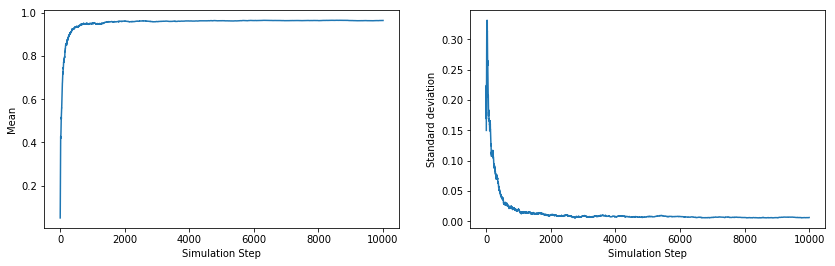

In [61]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(14,4))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(crs_mean)
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('Mean')

ax2.plot(crs_std)
ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Standard deviation')

plt.show()

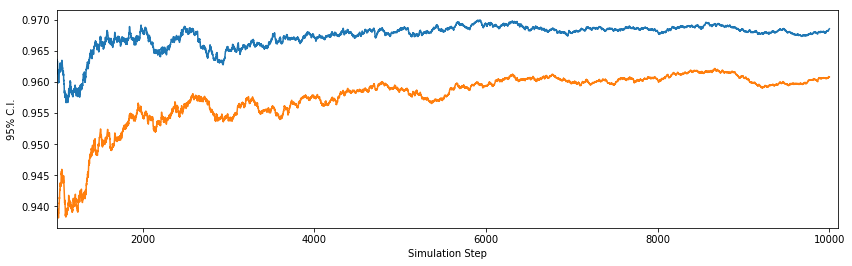

In [69]:
plt.close('all')
fig, ax = plt.subplots(figsize=(14,4))

ax.plot(range(1000,10000),crs_u[1000:])
ax.plot(range(1000,10000),crs_l[1000:])

ax.set_xlabel('Simulation Step')
ax.set_ylabel('95% C.I.')
ax.set_xlim([1000,10100])

plt.show()

In [84]:
def serv(classes, patientsList, mu, servList, T):
    rnum = poi.rvs(mu)
    servList.append([T, rnum])
    
    for j in range(rnum):
        c = policy1(classes, patientsList)
        if c:
            patientsList[c].curedClass = patientsList[c].currentClass
            patientsList[c].currentClass = -1
            patientsList[c].endTime = T
    return patientsList, servList

In [88]:
def mainSim(T_end, numClass, lambdas, mu, rho, alpha):
    classes, patientsList, rhoC = inputProcess(numClass, rho)
    T = 0
    servList = []
    while T <= T_end:
        # update patients status
        patientsList = pUpdate(classes, patientsList, alpha, rhoC, T)
         
        # check new arrivals
        patientsList = newArr(classes, patientsList, lambdas, alpha, T)     
   
        # check service
        patientsList,servList = serv_p1(classes, patientsList, mu, servList, T)
        
        T += 1
    return patientsList, servList

# Reward

In [384]:
c1 = []
c2 = []
c3 = []
for i in range(10):
    t_end = 5000
    pp, serv1 = mainSim_p2(t_end, numClass, lambdas, mu, rho, alpha)

    cured1 = 0
    cured2 = 0
    cured3 = 0

    for p in pp:
        if p.currentClass == -1:
            p_1 +=1
            if p.curedClass == 1:
                cured1 +=1
            if p.curedClass == 2:
                cured2 +=1
            if p.curedClass == 3:
                cured3 +=1

            
    c1.append(cured1/len(pp))
    c2.append(cured2/len(pp))
    c3.append(cured3/len(pp))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [402]:
for i in range(91,100):
    print(pp[i].classTime)

[0, 21, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 8, 0]
[0, 0, 0, 1]
[0, 0, 9, 1]
[0, 4, 5, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]


In [ ]:
r1 = 1
r2 = 3
r3 = 8

c11 = []
c12 = []
c13 = []
c21 = []
c22 = []
c23 = []

for i in range(10):
    t_end = 5000
    pp1, serv1 = mainSim_p1(t_end, numClass, lambdas, mu, rho, alpha)
    pp2, serv2 = mainSim_p2(t_end, numClass, lambdas, mu, rho, alpha)
    
    R1 = 0
    R2 = 0

    for p in pp1:
        if p.currentClass == -1:
            if p.curedClass == 1:
                R1 += r1
            if p.curedClass == 2:
                R1 += r2
            if p.curedClass == 3:
                R1 += r3
    print(i)

In [385]:
print(1.8/mu)
print(np.mean(c1))
print(np.mean(c2))
print(np.mean(c3))
print(1-np.mean(c1)-np.mean(c2)-np.mean(c3))

1.0
0.131800615307
0.317256738355
0.447209024456
0.103733621882


### Plot

In [386]:
t91 = [0.1129, 0.0000, 0.0000,0.8871]
t361 = [0.2738, 0.0003, 0.0000, 0.7259]
t21 = [0.4920, 0.0075, 0.0001, 0.5004]
t181 = [0.5392, 0.0159, 0.0002, 0.4447]
t121 = [0.4772, 0.3458, 0.0108, 0.1662]
t11 = [0.2718, 0.4240, 0.2690, 0.0352]
t751 = [0.2276, 0.3449, 0.4187, 0.0088]
t51 = [0.2256, 0.3332, 0.4380, 0.0032]
t021 = [0.2227, 0.3339, 0.4422, 0.0012]

t92 = [0.0000, 0, 0.11, 0.89]
t362 = [0.0000, 3.31528345674e-05, 0.277876124848, 0.722090722318]
t22 = [2.27221086117e-05, 0.0481039656407, 0.450018813635, 0.501854498616]
t182 = [0.000200879027205, 0.0880579803448, 0.462991035885, 0.448750104743]
t122 = [0.0647329998229, 0.287540409493, 0.453688576622, 0.194038014063]
t12 = [0.131800615307, 0.317256738355, 0.447209024456, 0.103733621882]
t752 = [0.193896682813, 0.323995808967, 0.446630621757, 0.035476886463]
t52 = [0.214832440122, 0.331881509516, 0.442618000595, 0.0106680497672]
t022 = [0.221470896036, 0.333495684559, 0.4416893317, 0.0033440877046]

t = [t91, t92, t361, t362, t21, t22, t181, t182, t121, t122, t11, t12, t751, t752, t51, t52, t021, t022]
t1 = [t91, t361, t21, t181, t121, t11, t751, t51, t021]
t2 = [t92, t362, t22, t182, t122, t12, t752, t52, t022]

w11 = []
w12 = []
w13 = []
w14 = []
for i in t1:
    w11.append(i[0])
    w12.append(i[1])
    w13.append(i[2])
    w14.append(i[3])
    
w21 = []
w22 = []
w23 = []
w24 = []
for i in t2:
    w21.append(i[0])
    w22.append(i[1])
    w23.append(i[2])
    w24.append(i[3])

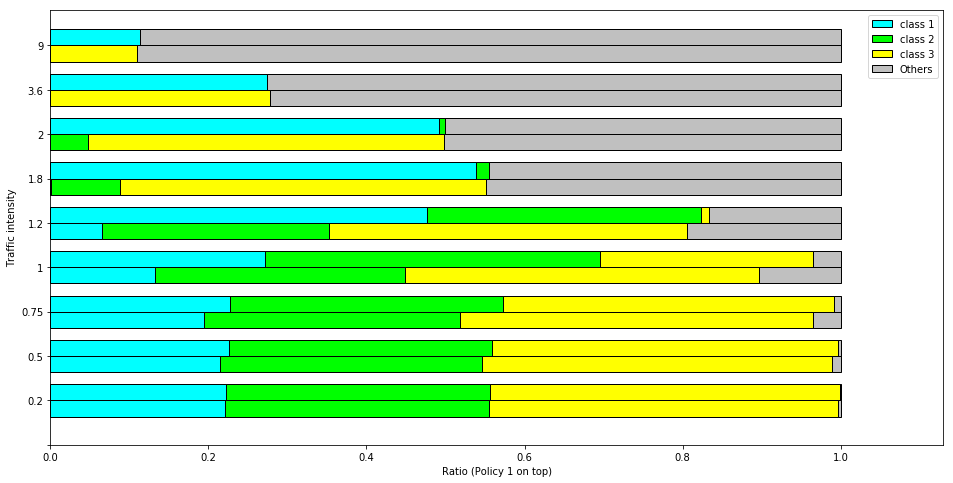

In [387]:
y_pos = [19.8, 17.6, 15.4, 13.2, 11, 8.8, 6.6, 4.4, 2.2, 0]
t_label = ('9', '3.6', '2', '1.8', '1.2', '1', '0.75', '0.5', '0.2')

plt.close('all')
fig, ax = plt.subplots(figsize=(16,8))

for i in range(9):
    if i == 0:
        ax.barh(y_pos[i], w11[i], color = 'aqua', edgecolor = 'k', align = 'edge',label = 'class 1')
        ax.barh(y_pos[i], w12[i], left = w11[i], color = 'lime', edgecolor = 'k', align = 'edge', label = 'class 2')
        ax.barh(y_pos[i], w13[i], left = w11[i]+w12[i], color = 'yellow', edgecolor = 'k', align = 'edge', label = 'class 3')
        ax.barh(y_pos[i], w14[i], left = w11[i]+w12[i]+w13[i], color = 'silver', edgecolor = 'k', align = 'edge', label = 'Others')

        ax.barh(y_pos[i], w21[i], color = 'aqua', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w22[i], left = w21[i], color = 'lime', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w23[i], left = w21[i]+w22[i], color = 'yellow', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w24[i], left = w21[i]+w22[i]+w23[i], color = 'silver', edgecolor = 'k', align = 'edge', height = -0.8)
    else:
        ax.barh(y_pos[i], w11[i], color = 'aqua', edgecolor = 'k', align = 'edge')
        ax.barh(y_pos[i], w12[i], left = w11[i], color = 'lime', edgecolor = 'k', align = 'edge')
        ax.barh(y_pos[i], w13[i], left = w11[i]+w12[i], color = 'yellow', edgecolor = 'k', align = 'edge')
        ax.barh(y_pos[i], w14[i], left = w11[i]+w12[i]+w13[i], color = 'silver', edgecolor = 'k', align = 'edge')

        ax.barh(y_pos[i], w21[i], color = 'aqua', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w22[i], left = w21[i], color = 'lime', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w23[i], left = w21[i]+w22[i], color = 'yellow', edgecolor = 'k', align = 'edge', height = -0.8)
        ax.barh(y_pos[i], w24[i], left = w21[i]+w22[i]+w23[i], color = 'silver', edgecolor = 'k', align = 'edge', height = -0.8)
    
ax.set_yticks(y_pos)
ax.set_yticklabels(t_label)
ax.set_ylabel('Traffic intensity')
ax.set_xlabel('Ratio (Policy 1 on top)')
ax.legend(loc = 1)
ax.set_xlim([0,1.13])
plt.show()

In [254]:
0.136637135052, 0.317781428118, 0.445280819044, 0.100300617786

[8, 7, 6, 5, 4, 3, 2, 1, 0]